In [2]:
import h5py
import numpy as np
%matplotlib inline
import matplotlib.style
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('classic')
from mpl_toolkits.axes_grid1 import make_axes_locatable
import subprocess

In [8]:
py_directory = "../"
py_directory += "output_acoustic_wave/"

def spatially_averaged_rmse(arr,ref):
    n,m = ref.shape
    N = n * m
    return np.sqrt(((arr - ref)**2).mean())

def get_filename(grid_x,grid_y,size,end_time,suffix):
    return "output_acoustic_wave_ensemble=" + str(size) + "_" + str(grid_x) + "_" + str(grid_y) + "_" + str(end_time) + suffix + ".h5"

def get_path(filename):
    return py_directory + filename

def py_out(pyfile,py_dataset,time):
    return pyfile[str(py_dataset)][str(py_dataset)+time][:]

def ensemble_test_case(time, path, N, attribute, label_type='TIME'):
    inner = (slice(2,-2),slice(2,-2))
    # inner = (slice(None,),slice(None,))
    file = h5py.File(path,'r')

    array = []
    for n in range(N):
        if label_type == 'TIME':
#             if N==1:
#                 t_label = '_%.2f_after_full_step' %(time)
#             else:
            t_label = '_ensemble_mem=%i_%.2f_after_full_step' %(n,time)
        elif label_type == 'STEP':
            if N==1:
                t_label = '_%.3d_after_full_step' %(time)
            else:
                t_label = '_ensemble_mem=%i_%.3d_after_full_step' %(n,time)
            
        array.append(py_out(file,attribute,time=t_label)[inner])

    array = np.array(array)
    array = array.mean(axis=0)

    file.close()
    file.close()
    return np.array(array)

def bin_func(obs,ens_mem_shape):
    obs = obs.reshape(ens_mem_shape[0],obs.shape[0]//ens_mem_shape[0],
                      ens_mem_shape[1],obs.shape[1]//ens_mem_shape[1])
    return obs.mean(axis=(1,3))

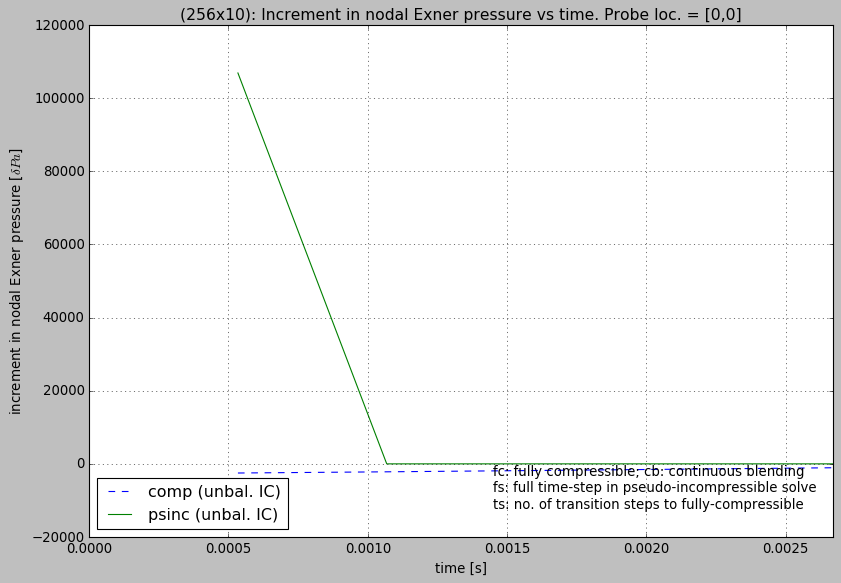

In [12]:
grid_x = 256
grid_y = 10
ens_size = 1
end_time = 0.00267
attribute = 'p2_nodes'

time = 1.0
time = 1

def get_arr(time, attribute, suffix, cont_blend=False, ts=0, fs=0, end_time=end_time):
    if cont_blend == True:
        suffix += '_cont_blend_fs=%i_ts=%i' %(fs,ts)
        
    fn = get_filename(grid_x, grid_y, ens_size, end_time, suffix)
    path = get_path(fn)
    
    return ensemble_test_case(time, path, ens_size, attribute, label_type='STEP')

Ns = 5
times = np.arange(0,Ns+1)
# times = times[10:]
dt = end_time / Ns
times_axis = times * dt

def get_diff(probe):
    probe = np.array(probe)
    return probe[1:] - probe[:-1]
#     return probe[:-1]


probe_row = 0
probe_col = 0
attribute = 'p2_nodes'
cb1 = [10,10]
cb2 = [20,20]

def get_time_series(times, attribute, suffix, cont_blend=False, ts=0, fs=0, end_time=end_time):
    probe = []
    for time in times:
        arr = get_arr(time, attribute, suffix, cont_blend, ts, fs, end_time=end_time)
        probe.append(arr[probe_row,probe_col])
        
    probe = np.array(probe)
    
    return get_diff(probe)
    
# probe = get_time_series(times,attribute,"_truth")
probe_fc = get_time_series(times,attribute,"_comp")
probe_psinc = get_time_series(times,attribute,"_psinc")
# probe_psinc = get_time_series(times,attribute,"_psinc_full_corrections")
# probe_psinc = get_time_series(times,attribute,"_psinc_nocorrection")
# probe_cb1 = get_time_series(times,attribute,"_nocorrection",cont_blend=True,fs=cb1[0],ts=cb1[1])
# probe_cb2 = get_time_series(times,attribute,"_nocorrection",cont_blend=True,fs=cb2[0],ts=cb2[1])

fig1 = plt.figure(figsize=(12,8))
# plt.plot(times_axis[1:],probe, label='comp (bal. IC)')
plt.plot(times_axis[1:],probe_fc, '--', label='comp (unbal. IC)')
plt.plot(times_axis[1:],probe_psinc, '-', label='psinc (unbal. IC)')
# plt.plot(times_axis[1:],probe_cb1, '-', label='cb: fs=%i, ts=%i' %(cb1[0],cb1[1]))
# plt.plot(times_axis[1:],probe_cb2, '--', label='cb: fs=%i, ts=%i' %(cb2[0],cb2[1]))

# plt.axvline(times_axis[1:][10])
# plt.axvline(times_axis[1:][20])
# plt.axvline(3.0)
plt.ylabel('increment in nodal Exner pressure [$\delta Pa$]', fontsize='12')
plt.xlabel('time [s]', fontsize='12')
plt.title("(%ix%i): Increment in nodal Exner pressure vs time. Probe loc. = [%i,%i]" %(grid_x,grid_y,probe_row,probe_col), fontsize='14')
txt = '''
        fc: fully compressible; cb: continuous blending
        fs: full time-step in pseudo-incompressible solve
        ts: no. of transition steps to fully-compressible
        '''
fig1.text(.51,.12,txt,fontsize='12')
plt.xlim([times_axis[0],times_axis[-1]])
plt.legend(loc='lower left')
plt.grid()
plt.show()

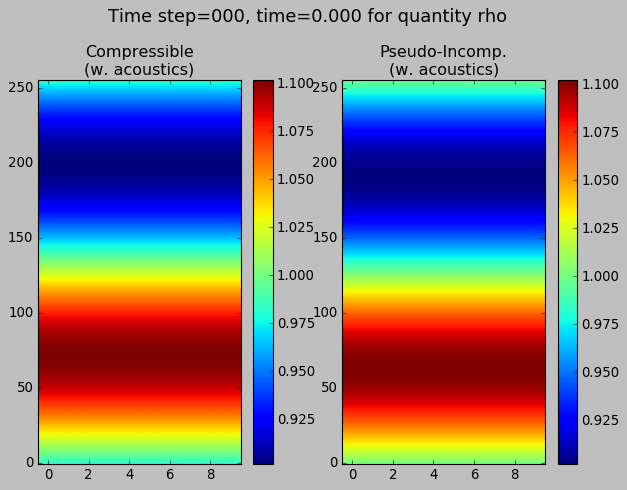

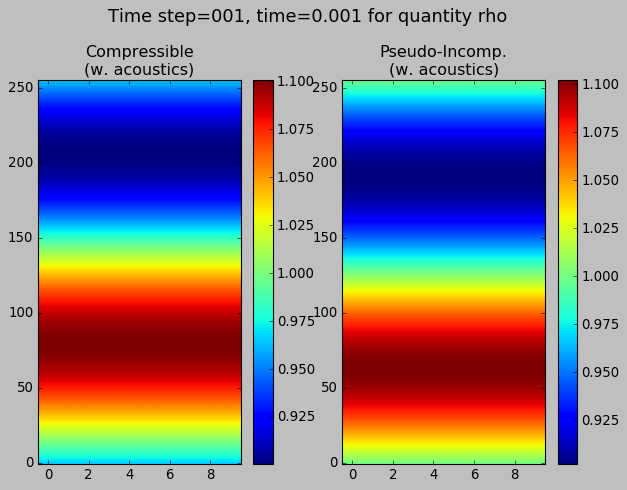

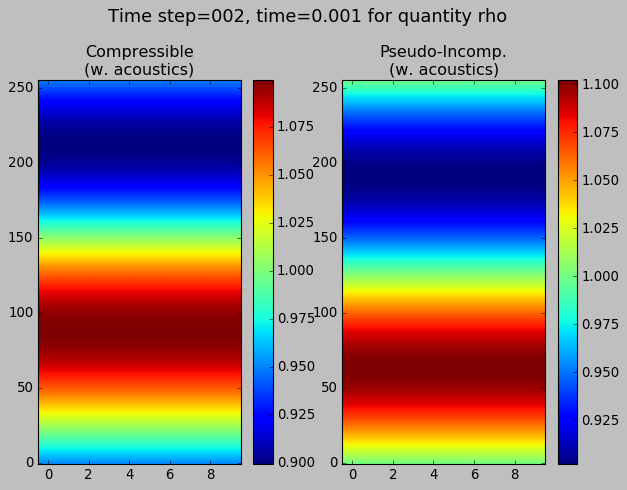

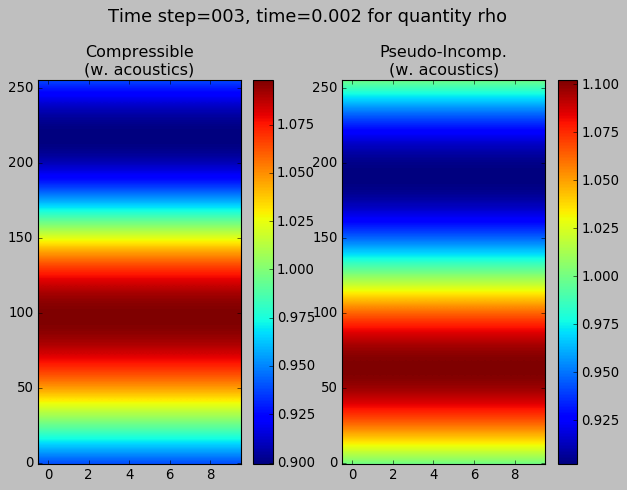

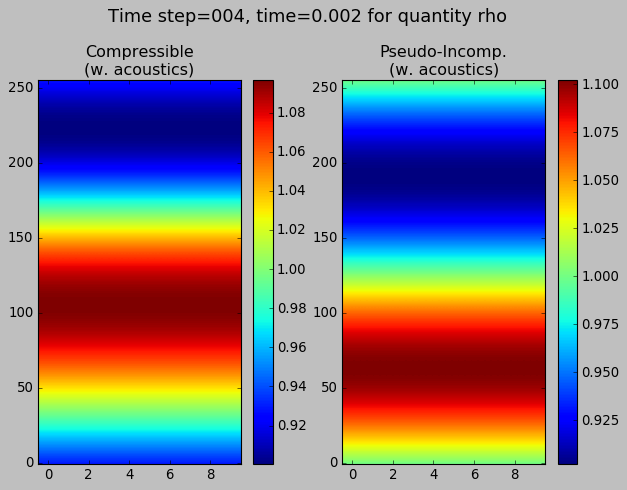

In [22]:

attribute = 'rho'
def get_time_series(times, attribute, suffix, cont_blend=False, ts=0, fs=0, end_time=end_time):
    probe = []
    for time in times:
        arr = get_arr(time, attribute, suffix, cont_blend, ts, fs, end_time=end_time)
        probe.append(arr)
        
    return np.array(probe)
    
# truth = get_time_series(times,attribute,"_truth")
comp = get_time_series(times,attribute,"_comp")
psinc = get_time_series(times,attribute,"_psinc")
# cb1_arr = get_time_series(times,attribute,"",cont_blend=True,fs=cb1[0],ts=cb1[1])
# cb2_arr = get_time_series(times,attribute,"",cont_blend=True,fs=cb2[0],ts=cb2[1])


sfactor = 1.0
# for i in range(80):
cnt = 0

# truth = truth[1:] - truth[:-1]
# comp = comp[1:] - comp[:-1]
# psinc = psinc[1:] - psinc[:-1]
# print(psinc.shape)

for i in range(len(times)-1):
    fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(9,6))
#     im0 = ax[0,0].imshow(truth[i], origin="lower")
#     ax[0,0].set_title("Compressible\n(analytical)")
#     fig.colorbar(im0,ax=ax[0,0],shrink=sfactor)
    
    im1 = ax[0].imshow(comp[i], origin="lower", aspect='auto')
    ax[0].set_title("Compressible\n(w. acoustics)")
    fig.colorbar(im1,ax=ax[0],shrink=sfactor)
    
    im2 = ax[1].imshow(psinc[i], origin="lower", aspect='auto')
    ax[1].set_title("Pseudo-Incomp.\n(w. acoustics)")
    fig.colorbar(im2,ax=ax[1],shrink=sfactor)
    
#     im3 = ax[1,0].imshow(cb1_arr[i], origin="lower")
#     ax[1,0].set_title("Continuous blending \n (fs=%i, ts=%i)" %(cb1[0],cb1[1]))
#     fig.colorbar(im3,ax=ax[1,0],shrink=sfactor)
    
#     im4 = ax[1,1].imshow(cb2_arr[i], origin="lower")
#     fig.colorbar(im4,ax=ax[1,1],shrink=sfactor)
#     ax[1,1].set_title("Continuous blending \n (fs=%i, ts=%i)" %(cb2[0],cb2[1]))
    
#     fig.delaxes(ax[1,2])
    fig.suptitle(r'Time step=%.3d, time=%.3f for quantity %s' %(i,times_axis[i],attribute), fontsize='16',y=1.05)

#     plt.savefig("../output_images/%s_%03d" %(attribute,cnt), bbox_inches='tight')
#     plt.close()
    plt.show()
    cnt += 1
#     plt.gca.clear()